# Packages and OS

In [79]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [80]:
# generic packages
import os
import numpy as np
import matplotlib.pyplot as plt
import sys
from tqdm.auto import tqdm
from datetime import datetime
import pandas as pd

# # os directory
YOUR_FOLDER_DIRECTORY = os.getcwd()

# Assuming 'src' directory is located one level above the notebook directory
project_directory = os.path.join(YOUR_FOLDER_DIRECTORY, '..')
sys.path.append(project_directory)

# src code
from src.portfolio_class_240309 import Portfolio
from src.config import (
    TICKERS,
    START_DATE,
    END_DATE,
    INTERVAL,
    RISK_FREE_RATE,
    MSCI_SCORE_ALREADY_DOWNLOADED,
    FREQUENCY_RETURNS
)
from src.backtesting_score import (
    get_last_esg_scores,
    get_first_date_with_all_msci_score_available
)

# scraper code
from exploration.scrapper.scraper import (
    download_msci_esg_ratings_htmlfile,
    load_dict_from_json
)


# Download MSCI data

In [68]:
if MSCI_SCORE_ALREADY_DOWNLOADED:
    # load data
    msci_score = load_dict_from_json("../data/exemple_msci_esg_ratings_numeric.json")
else:
    # scrap data
    msci_score={}
    for ticker in tqdm(TICKERS):
        dict = download_msci_esg_ratings_htmlfile(tickers=[ticker])
        msci_score[ticker] = dict[ticker]

    for ticker in msci_score.keys():
        for key, rating in msci_score[ticker]['esg_score_dict'].items():
            key = datetime.strptime(key, '%b-%y').strftime('%Y-%m-%d')
    # # save data
    # from src.config import save_dict_to_json
    # save_dict_to_json(msci_score, "../data/exemple_msci_esg_ratings_numeric.json")
    # MSCI_SCORE_ALREADY_DOWNLOADED=True


# 1. Get optimal weights under constraints

In [69]:
END_DATE = '2022-12-01'

if datetime.strptime(END_DATE, '%Y-%m-%d') < get_first_date_with_all_msci_score_available(msci_score):
    print("ERROR: END_DATE is before the first date with all msci score available.")
    END_DATE = get_first_date_with_all_msci_score_available(msci_score)
    print(f"END_DATE is now {END_DATE}, but you can change it.")
else:
    print("Thanks for having entered a valid end date !")

Thanks for having entered a valid end date !


In [70]:
msci_last_esg_score = get_last_esg_scores(msci_score, END_DATE)

PORTFOLIO = Portfolio(TICKERS,
                      START_DATE,
                      END_DATE,
                      INTERVAL,
                      msci_last_esg_score,
                      FREQUENCY_RETURNS)

PORTFOLIO.download_data()

[                       0%%                      ]

[*********************100%%**********************]  31 of 31 completed


In [71]:
MAX_ESG_SCORE = 60
MAX_ESG_SCORES = list(np.linspace(np.min(msci_last_esg_score), np.max(msci_last_esg_score), 30))
GAMMA_VALUES = np.linspace(-5, 5, 100)  # Inverse of the risk aversion parameter


# Exporter les tables de données

In [185]:
# data_to_keep = []
# for i in range(len(TICKERS)):
#     list_to_be_flattened = [list(msci_score[ticker]['esg_score_dict'].items()) for ticker in PORTFOLIO.tickers][i]
#     flattened_data = [item for sublist in list_to_be_flattened for item in sublist]
#     data_to_keep.append(flattened_data)
# df_data_to_keep = pd.DataFrame(data_to_keep, columns=['Date_1', 'Score_1', 'Date_2', 'Score_2', 'Date_3', 'Score_3', 'Date_4', 'Score_4', 'Date_5', 'Score_5'])
# df_data_to_keep


In [186]:
# df_to_latex = pd.DataFrame(data=PORTFOLIO.ticker_sector_dict.values(),
#                         index=PORTFOLIO.ticker_sector_dict.keys(),
#                         columns=['Sectors']).sort_values(by='Sectors').reset_index(names='Tickers')
# df_to_latex
# # print(df_to_latex.to_latex())

In [184]:
print(df_to_latex.set_index('Tickers').to_latex())

\begin{tabular}{ll}
\toprule
 & Sectors \\
Tickers &  \\
\midrule
DIS & Communication Services \\
GOOGL & Communication Services \\
AMZN & Consumer Cyclical \\
TSLA & Consumer Cyclical \\
F & Consumer Cyclical \\
WMT & Consumer Defensive \\
PG & Consumer Defensive \\
COST & Consumer Defensive \\
KO & Consumer Defensive \\
PEP & Consumer Defensive \\
XOM & Energy \\
CVX & Energy \\
BP & Energy \\
TTE & Energy \\
BAC & Financial Services \\
MA & Financial Services \\
JPM & Financial Services \\
V & Financial Services \\
JNJ & Healthcare \\
PFE & Healthcare \\
MRK & Healthcare \\
ABT & Healthcare \\
UNH & Healthcare \\
GE & Industrials \\
BA & Industrials \\
MMM & Industrials \\
CAT & Industrials \\
HON & Industrials \\
AAPL & Technology \\
MSFT & Technology \\
NVDA & Technology \\
\bottomrule
\end{tabular}



In [187]:
# print(pd.concat([df_to_latex, df_data_to_keep], axis=1).set_index('Tickers').to_latex())

In [188]:
# controverse_to_keep = []
# for i in range(len(TICKERS)):
#     controverse_colors = [list(msci_score[ticker]['controversy_info'].values()) for ticker in PORTFOLIO.tickers][i]
#     controverse_to_keep.append(controverse_colors)
# df_controverse_to_keep = pd.DataFrame(controverse_to_keep, columns=['Color for Environment', 'Color for Social', 'Color for Governance'])
# df_controverse_to_keep

In [189]:
# print(pd.concat([df_to_latex, df_controverse_to_keep], axis=1).set_index('Tickers').to_latex())

## 1.1. Market optimum

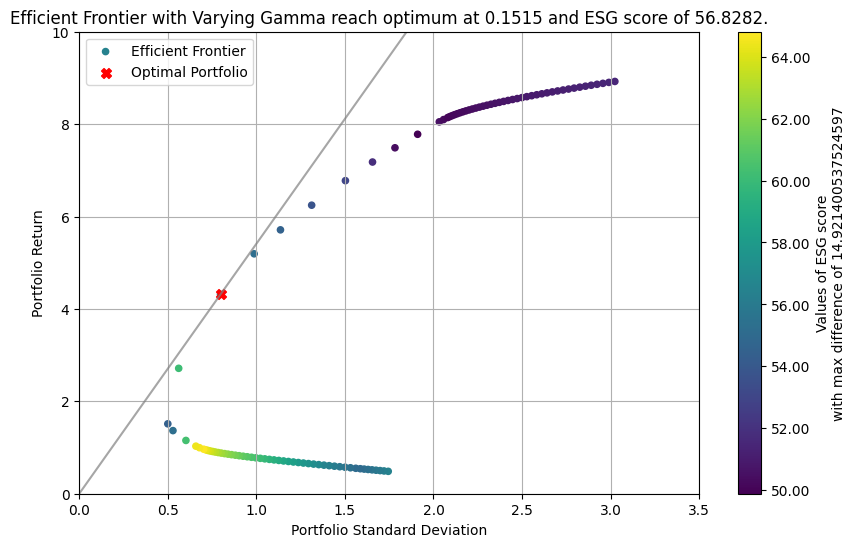

In [88]:
# efficient_frontier_no_esg_min.png
PORTFOLIO.plot_efficient_frontier(GAMMA_VALUES, 
                                  risk_free_rate=RISK_FREE_RATE,
                                  max_esg_score=0,
                                  fully_invested=True,
                                  long_only=True)


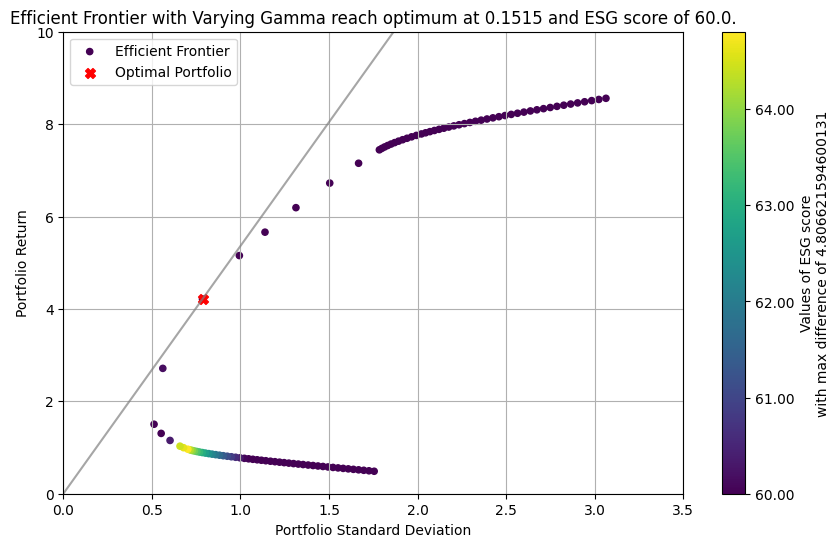

In [89]:
# efficient_frontier_60_esg_min.png
PORTFOLIO.plot_efficient_frontier(GAMMA_VALUES, 
                                  risk_free_rate=RISK_FREE_RATE,
                                  max_esg_score=MAX_ESG_SCORE,
                                  fully_invested=True,
                                  long_only=True)


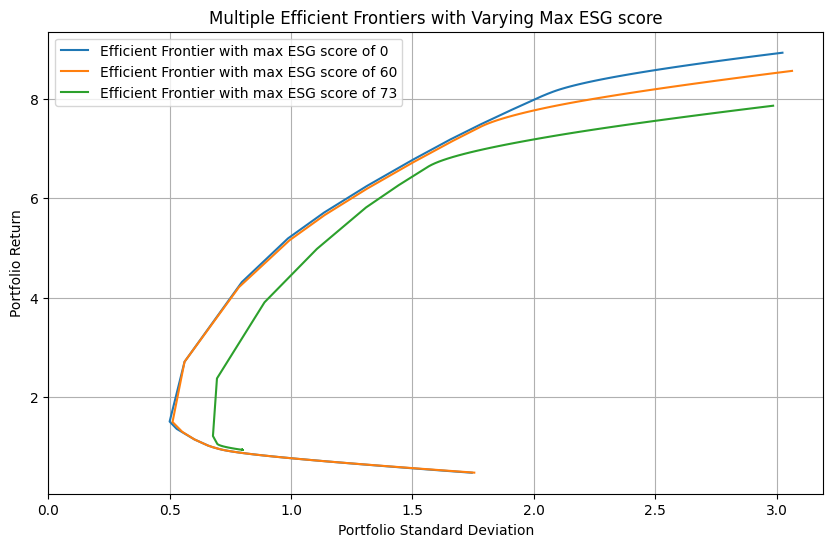

In [90]:
# multiple_efficient_frontier_esg_min.png
PORTFOLIO.plot_efficient_frontier_multiple_max_esg_scores(GAMMA_VALUES, 
                                  risk_free_rate=RISK_FREE_RATE,
                                  max_esg_scores=[0, MAX_ESG_SCORE, 73],
                                  fully_invested=True,
                                  long_only=True)

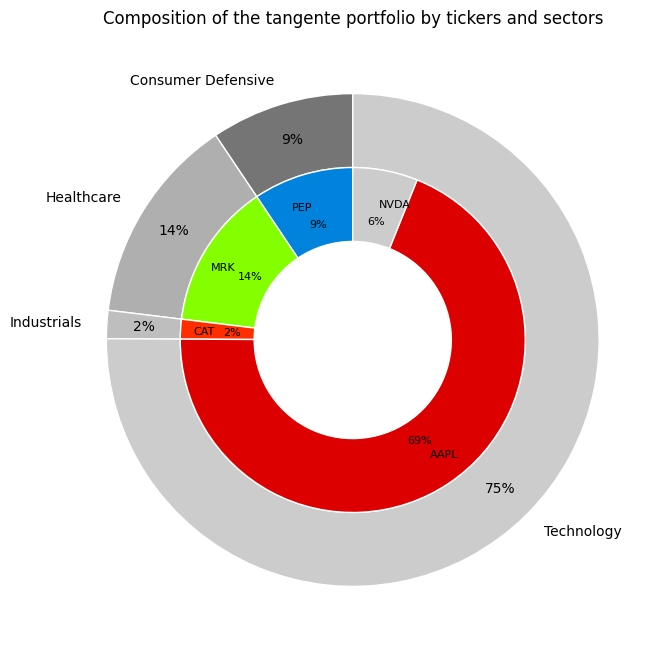

In [91]:
# tangente_portfolio_composition_no_esg_min.png
PORTFOLIO.plot_tangente_portfolio_composition(GAMMA_VALUES, 
                                  risk_free_rate=RISK_FREE_RATE,
                                  max_esg_score=0,
                                  fully_invested=True,
                                  long_only=True)

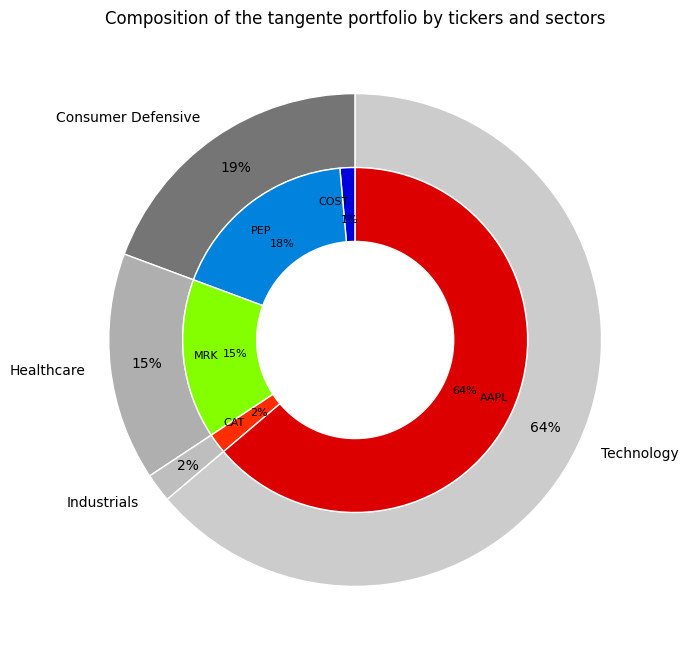

In [92]:
# tangente_portfolio_composition_60_esg_min.png
PORTFOLIO.plot_tangente_portfolio_composition(GAMMA_VALUES, 
                                  risk_free_rate=RISK_FREE_RATE,
                                  max_esg_score=MAX_ESG_SCORE,
                                  fully_invested=True,
                                  long_only=True)

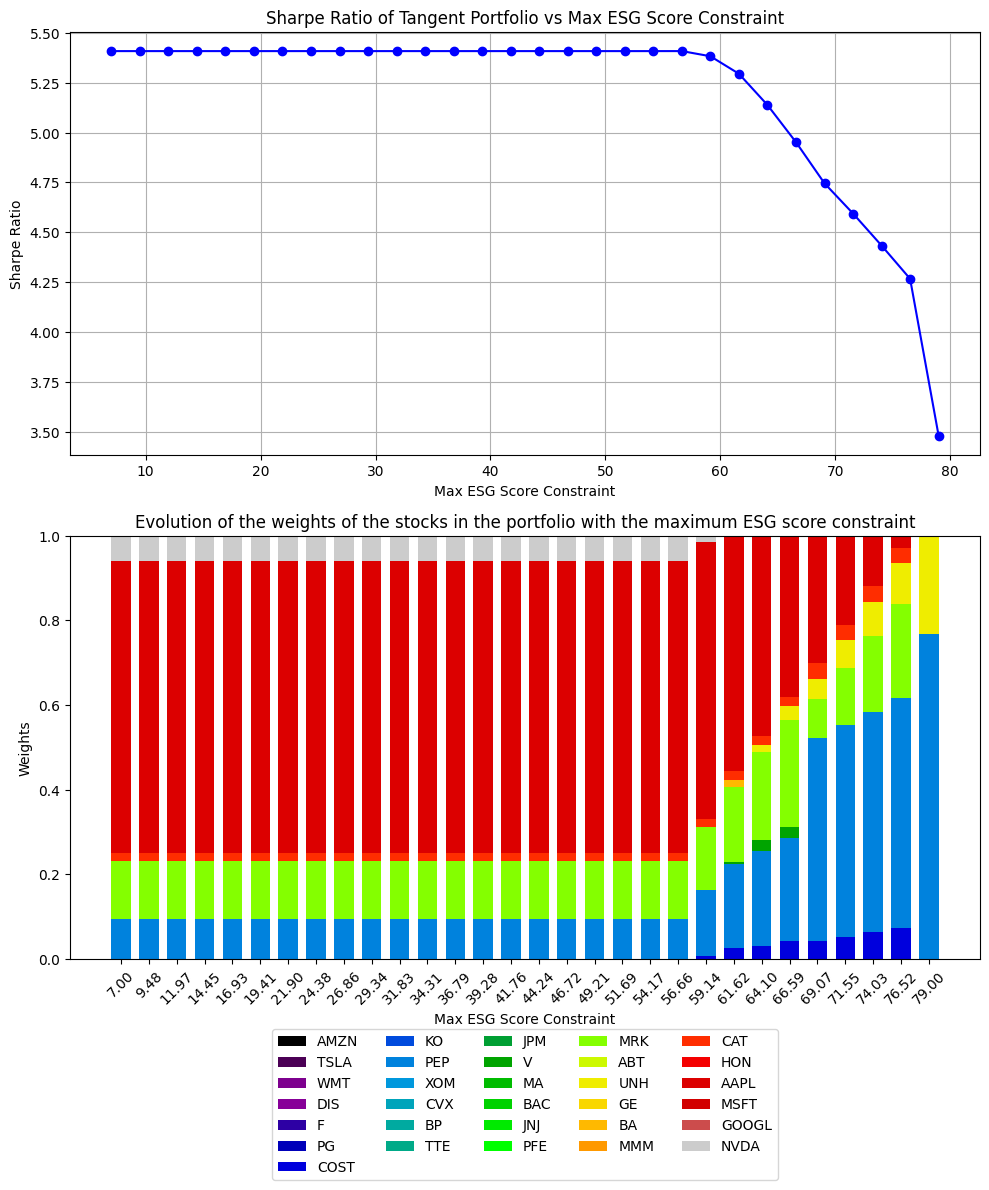

In [81]:
# sharpe_ratio_and_weights_varying_esg_limit.png
PORTFOLIO.plot_sharpe_ratio_and_weights_varying_esg_limit(GAMMA_VALUES,
                                        risk_free_rate=RISK_FREE_RATE,
                                        max_esg_scores=MAX_ESG_SCORES,
                                        fully_invested=True,
                                        long_only=True,
                                        best_in_class_method=1,
                                        best_in_class_strategy='global')

In [95]:
# # sharp_ratio_vs_max_score.png
# PORTFOLIO.plot_sharp_ratio_vs_max_score(GAMMA_VALUES,
#                                         risk_free_rate=RISK_FREE_RATE,
#                                         max_esg_scores=MAX_ESG_SCORES,
#                                         fully_invested=True,
#                                         long_only=True,
#                                         best_in_class_method=1,
#                                         best_in_class_strategy='global')


In [96]:
# # weights_evolution_with_esg.png
# PORTFOLIO.plot_weights_evolution(GAMMA_VALUES,
#                                  risk_free_rate=RISK_FREE_RATE,
#                                  max_esg_scores=MAX_ESG_SCORES,
#                                  fully_invested=True,
#                                  long_only=True, 
#                                  best_in_class_method=1,
#                                  best_in_class_strategy='global')

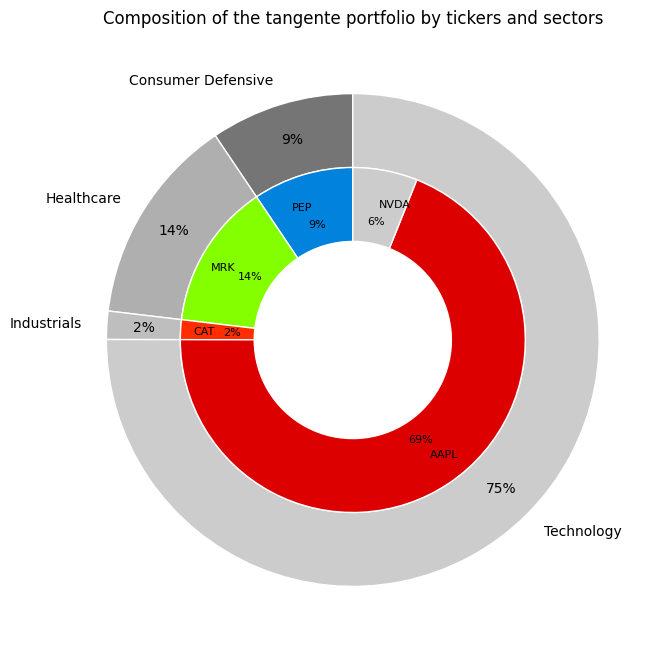

In [93]:
# tangente_portfolio_composition_55_esg_min.png
PORTFOLIO.plot_tangente_portfolio_composition(gammas=GAMMA_VALUES, 
                                            risk_free_rate=RISK_FREE_RATE,
                                            max_esg_score=55,
                                            fully_invested=True,
                                            long_only=True,
                                            best_in_class_method=1,
                                            best_in_class_strategy='global')

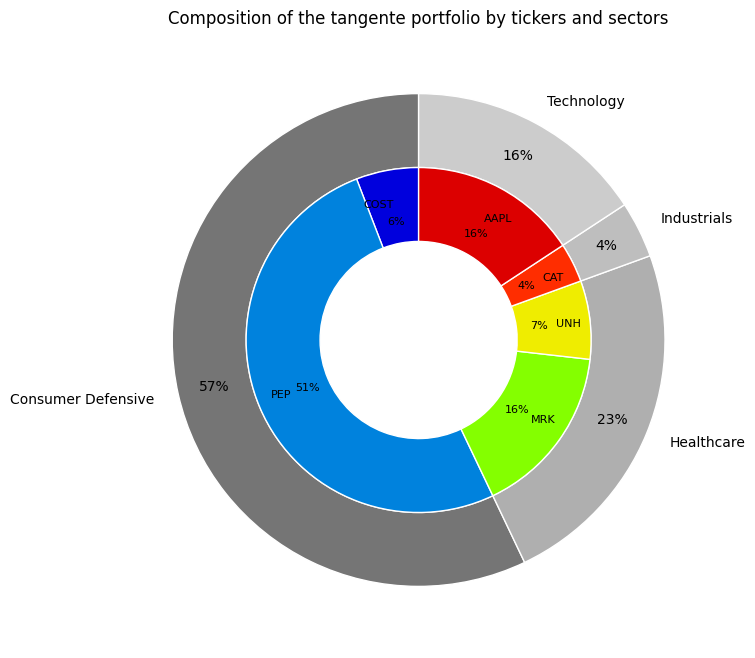

In [94]:
# tangente_portfolio_composition_73_esg_min.png
PORTFOLIO.plot_tangente_portfolio_composition(gammas=GAMMA_VALUES, 
                                            risk_free_rate=RISK_FREE_RATE,
                                            max_esg_score=73,
                                            fully_invested=True,
                                            long_only=True,
                                            best_in_class_method=1,
                                            best_in_class_strategy='global')

## 1.2. Selection 50% best global scale

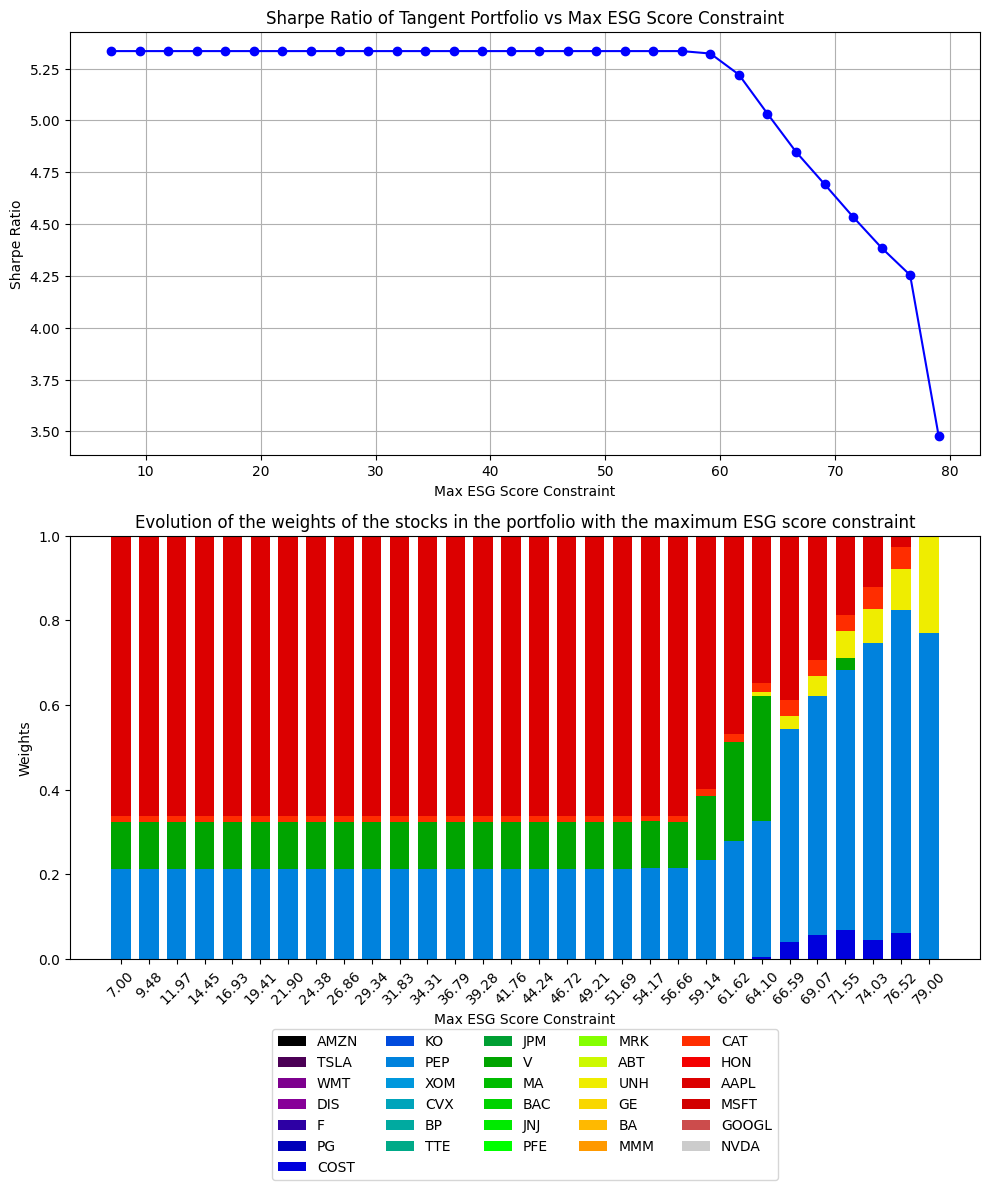

In [97]:
# sharpe_ratio_and_weights_varying_esg_limit_50_pourcent_global.png
PORTFOLIO.plot_sharpe_ratio_and_weights_varying_esg_limit(GAMMA_VALUES,
                                        risk_free_rate=RISK_FREE_RATE,
                                        max_esg_scores=MAX_ESG_SCORES,
                                        fully_invested=True,
                                        long_only=True,
                                        best_in_class_method=0.5,
                                        best_in_class_strategy='global')


In [98]:
# # sharp_ratio_vs_max_score_50_pourcent_global.png
# PORTFOLIO.plot_sharp_ratio_vs_max_score(GAMMA_VALUES,
#                                         risk_free_rate=RISK_FREE_RATE,
#                                         max_esg_scores=MAX_ESG_SCORES,
#                                         fully_invested=True,
#                                         long_only=True,
#                                         best_in_class_method=0.5,
#                                         best_in_class_strategy='global')


In [99]:
# # weights_evolution_50_pourcent_global.png
# PORTFOLIO.plot_weights_evolution(GAMMA_VALUES,
#                                  risk_free_rate=RISK_FREE_RATE,
#                                  max_esg_scores=MAX_ESG_SCORES,
#                                  fully_invested=True,
#                                  long_only=True, 
#                                  best_in_class_method=0.5,
#                                  best_in_class_strategy='global')

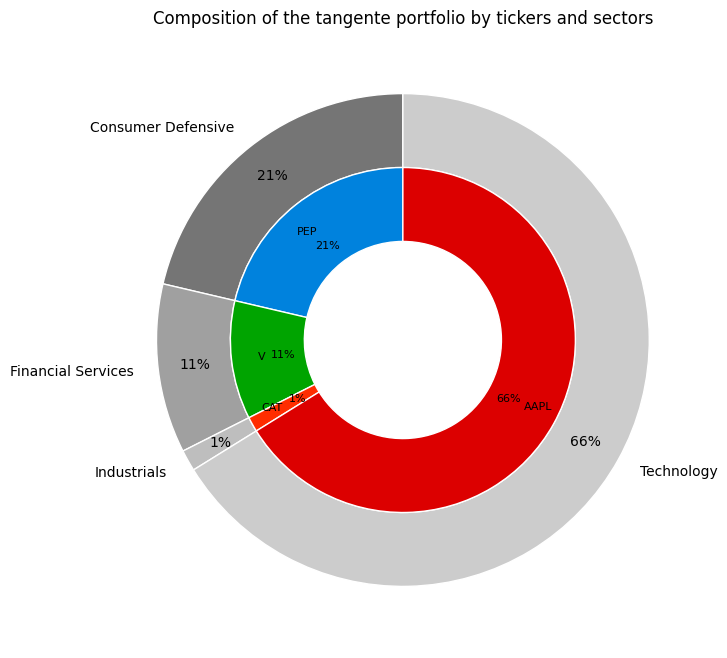

In [100]:
# tangente_portfolio_composition_no_esg_min_50_pourcent_global.png
PORTFOLIO.plot_tangente_portfolio_composition(gammas=GAMMA_VALUES, 
                                            risk_free_rate=RISK_FREE_RATE,
                                            max_esg_score=0,
                                            fully_invested=True,
                                            long_only=True,
                                            best_in_class_method=0.5,
                                            best_in_class_strategy='global')

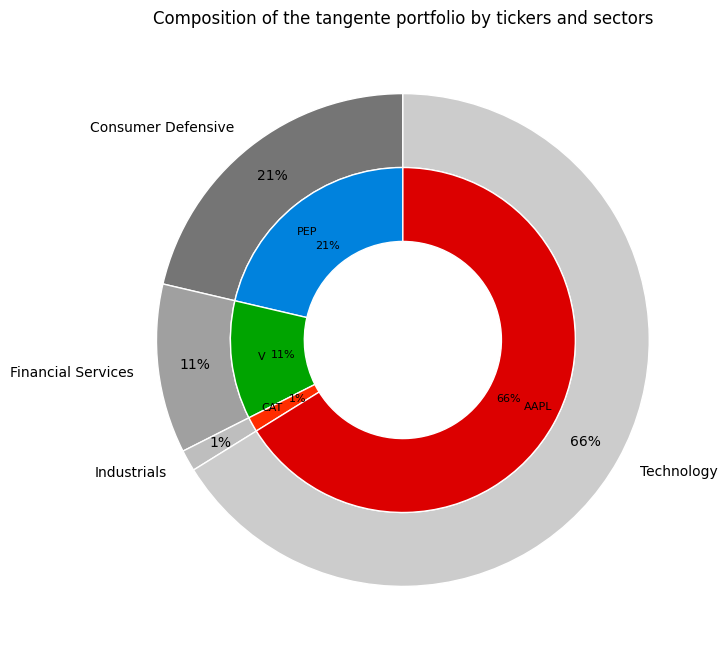

In [101]:
# tangente_portfolio_composition_55_esg_min_50_pourcent_global.png
PORTFOLIO.plot_tangente_portfolio_composition(gammas=GAMMA_VALUES, 
                                            risk_free_rate=RISK_FREE_RATE,
                                            max_esg_score=55,
                                            fully_invested=True,
                                            long_only=True,
                                            best_in_class_method=0.5,
                                            best_in_class_strategy='global')

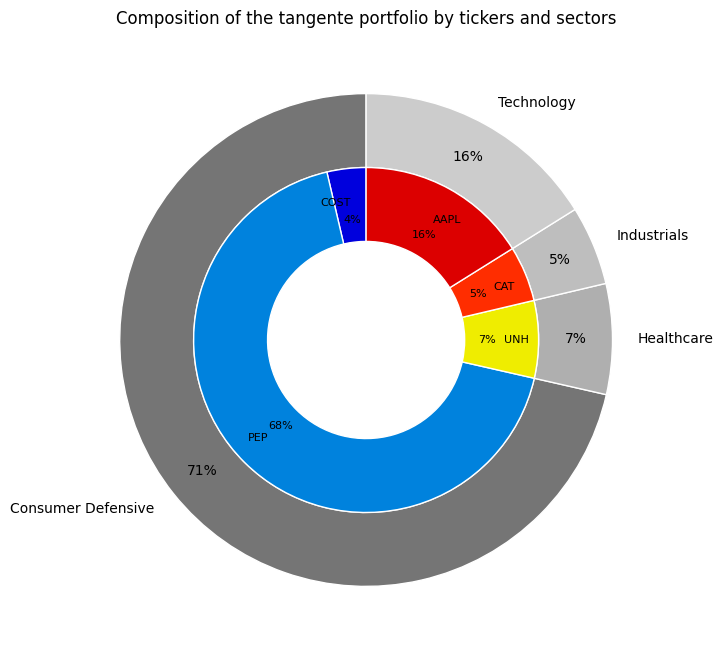

In [102]:
# tangente_portfolio_composition_73_esg_min_50_pourcent_global.png
PORTFOLIO.plot_tangente_portfolio_composition(gammas=GAMMA_VALUES, 
                                            risk_free_rate=RISK_FREE_RATE,
                                            max_esg_score=73,
                                            fully_invested=True,
                                            long_only=True,
                                            best_in_class_method=0.5,
                                            best_in_class_strategy='global')


## 1.3. Selection 50% best sector scale

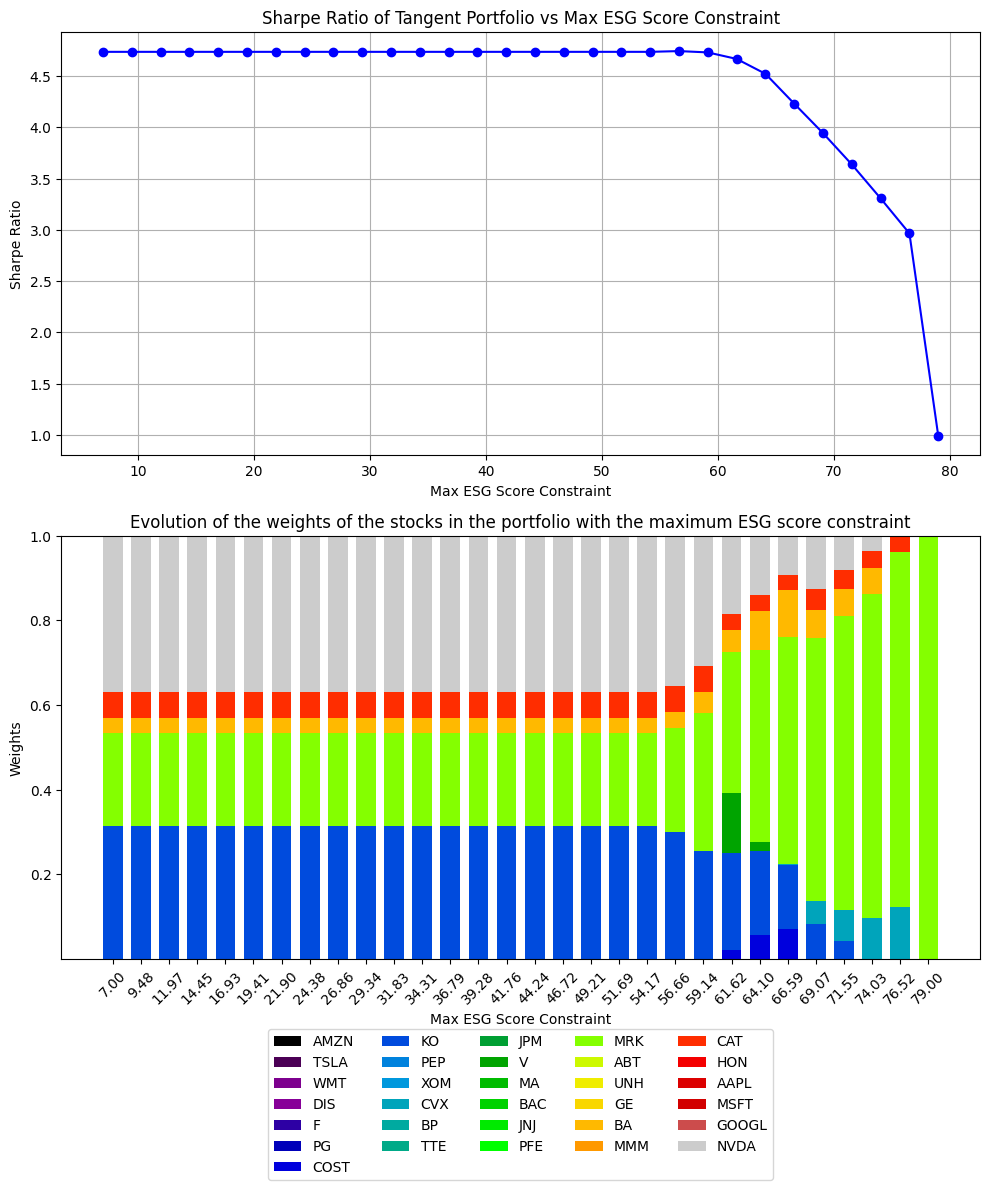

In [103]:
# sharpe_ratio_and_weights_varying_esg_limit_50_pourcent_sector.png
PORTFOLIO.plot_sharpe_ratio_and_weights_varying_esg_limit(GAMMA_VALUES,
                                        risk_free_rate=RISK_FREE_RATE,
                                        max_esg_scores=MAX_ESG_SCORES,
                                        fully_invested=True,
                                        long_only=True,
                                        best_in_class_method=0.5,
                                        best_in_class_strategy='sector')


In [104]:
# # sharp_ratio_vs_max_score_50_pourcent_sector.png
# PORTFOLIO.plot_sharp_ratio_vs_max_score(GAMMA_VALUES,
#                                         risk_free_rate=RISK_FREE_RATE,
#                                         max_esg_scores=MAX_ESG_SCORES,
#                                         fully_invested=True,
#                                         long_only=True,
#                                         best_in_class_method=0.5,
#                                         best_in_class_strategy='sector')


In [105]:
# # weights_evolution_50_pourcent_sector.png
# PORTFOLIO.plot_weights_evolution(GAMMA_VALUES,
#                                  risk_free_rate=RISK_FREE_RATE,
#                                  max_esg_scores=MAX_ESG_SCORES,
#                                  fully_invested=True,
#                                  long_only=True, 
#                                  best_in_class_method=0.5,
#                                  best_in_class_strategy='sector')

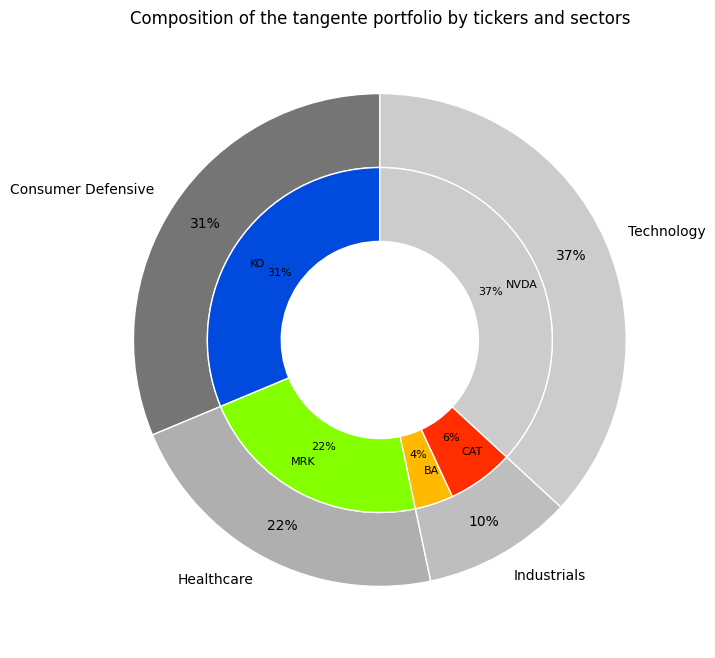

In [58]:
# tangente_portfolio_composition_no_esg_min_50_pourcent_sector.png
PORTFOLIO.plot_tangente_portfolio_composition(gammas=GAMMA_VALUES, 
                                            risk_free_rate=RISK_FREE_RATE,
                                            max_esg_score=0,
                                            fully_invested=True,
                                            long_only=True,
                                            best_in_class_method=0.5,
                                            best_in_class_strategy='sector')


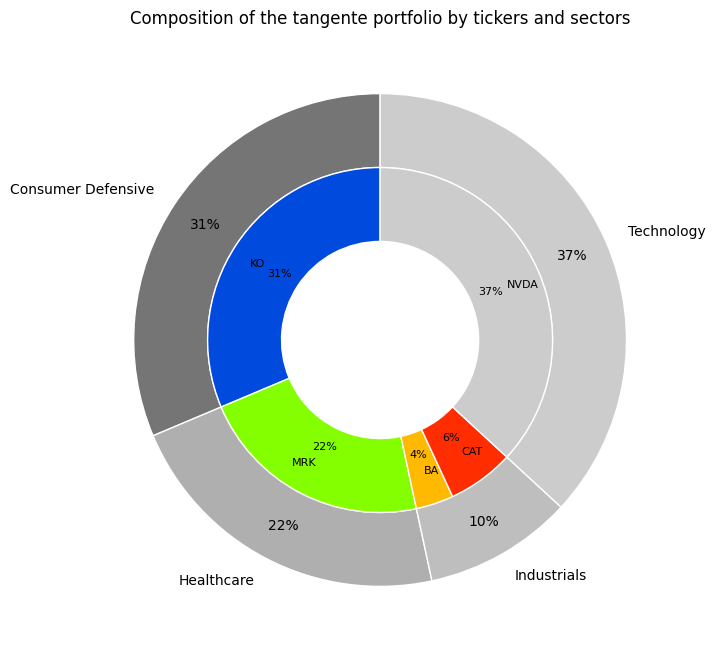

In [59]:
# tangente_portfolio_composition_55_esg_min_50_pourcent_sector.png
PORTFOLIO.plot_tangente_portfolio_composition(gammas=GAMMA_VALUES, 
                                            risk_free_rate=RISK_FREE_RATE,
                                            max_esg_score=55,
                                            fully_invested=True,
                                            long_only=True,
                                            best_in_class_method=0.5,
                                            best_in_class_strategy='sector')


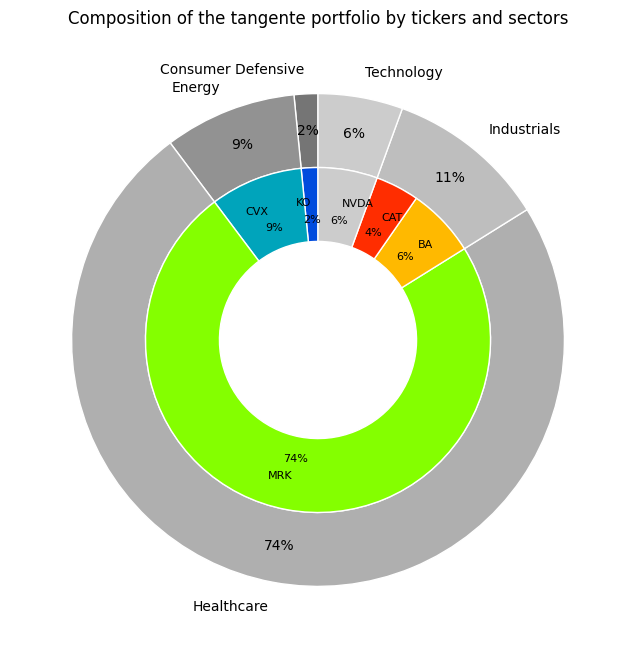

In [60]:
# tangente_portfolio_composition_73_esg_min_50_pourcent_sector.png
PORTFOLIO.plot_tangente_portfolio_composition(gammas=GAMMA_VALUES, 
                                            risk_free_rate=RISK_FREE_RATE,
                                            max_esg_score=73,
                                            fully_invested=True,
                                            long_only=True,
                                            best_in_class_method=0.5,
                                            best_in_class_strategy='sector')


## 1.4. Fixing lower bound on investment per sector

In [109]:
# Ne devrait pas marcher 
# SECTOR_MIN_WEIGHT_X_DICT_EQUAL_WEIGHTED = {sector_name: len(set(PORTFOLIO.get_sector_for_tickers().values())) 
#                                            for sector_name in set(PORTFOLIO.get_sector_for_tickers().values())}

SECTOR_MIN_WEIGHT_X_DICT_SOME_MINS = {'Communication Services': 0,
                                      'Consumer Cyclical': 0,
                                      'Consumer Defensive': 0,
                                      'Energy': 0.1,
                                      'Financial Services': 0,
                                      'Healthcare': 0,
                                      'Industrials': 0,
                                      'Technology': 0}


### 1.4.1. Lower bound - Market optimum

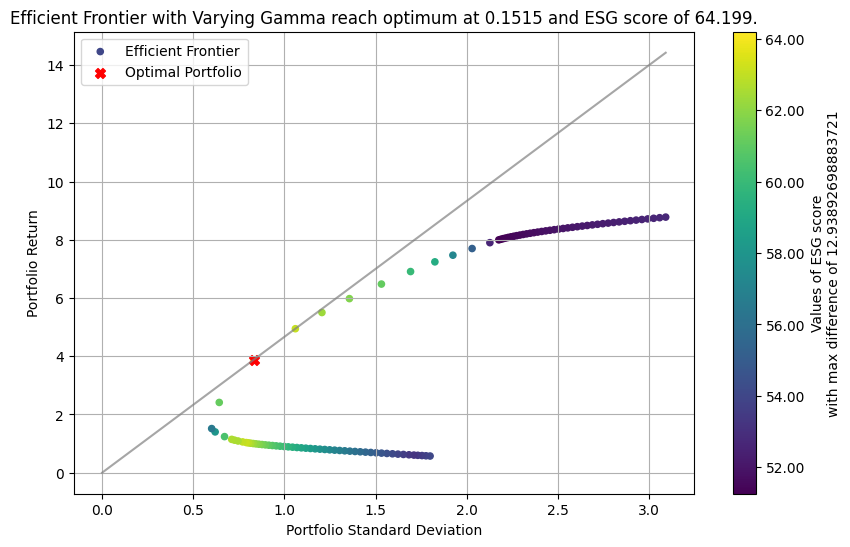

In [62]:
# efficient_frontier_no_esg_min_sector_lower_bound_investment.png
PORTFOLIO.plot_efficient_frontier(GAMMA_VALUES, 
                                  risk_free_rate=RISK_FREE_RATE,
                                  max_esg_score=0,
                                  fully_invested=True,
                                  long_only=True,
                                  sector_min_weight_x_dict=SECTOR_MIN_WEIGHT_X_DICT_SOME_MINS)

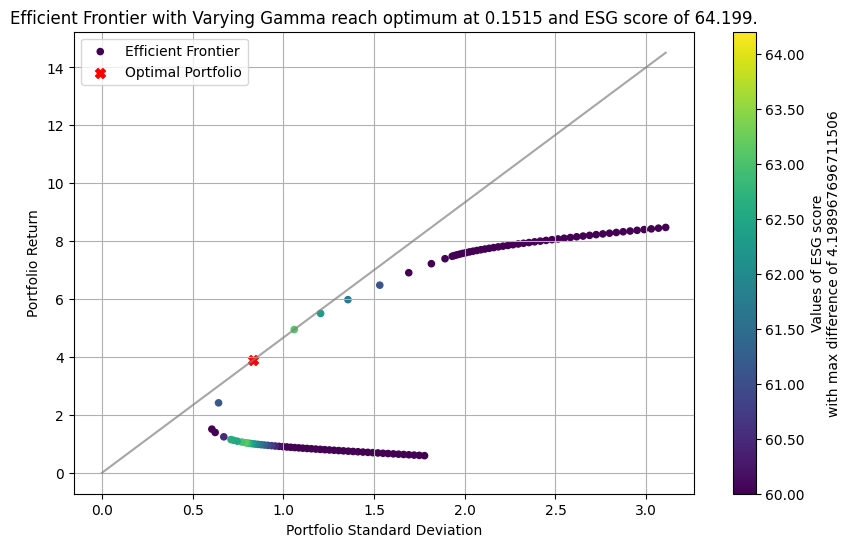

In [63]:
# efficient_frontier_60_esg_min_sector_lower_bound_investment.png
PORTFOLIO.plot_efficient_frontier(GAMMA_VALUES, 
                                  risk_free_rate=RISK_FREE_RATE,
                                  max_esg_score=MAX_ESG_SCORE,
                                  fully_invested=True,
                                  long_only=True,
                                  sector_min_weight_x_dict=SECTOR_MIN_WEIGHT_X_DICT_SOME_MINS)

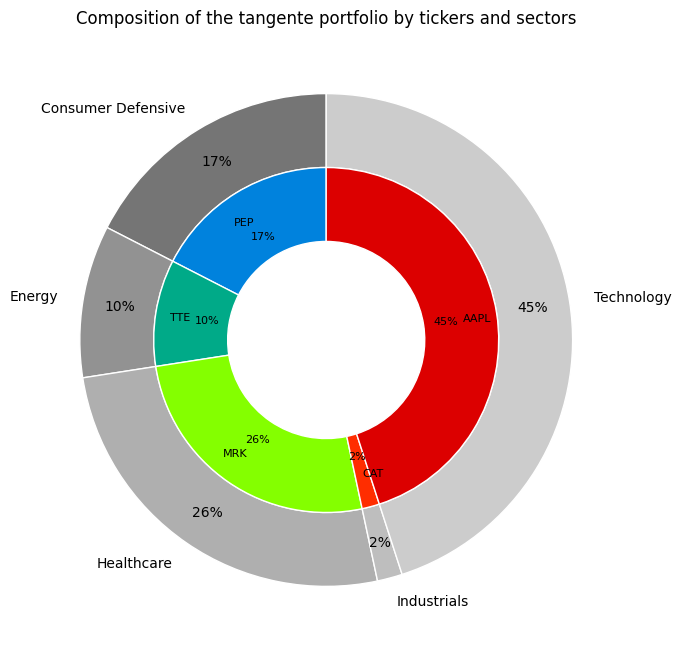

In [64]:
# tangente_portfolio_composition_no_esg_min_sector_lower_bound_investment.png
PORTFOLIO.plot_tangente_portfolio_composition(GAMMA_VALUES, 
                                  risk_free_rate=RISK_FREE_RATE,
                                  max_esg_score=0,
                                  fully_invested=True,
                                  long_only=True,
                                  sector_min_weight_x_dict=SECTOR_MIN_WEIGHT_X_DICT_SOME_MINS)

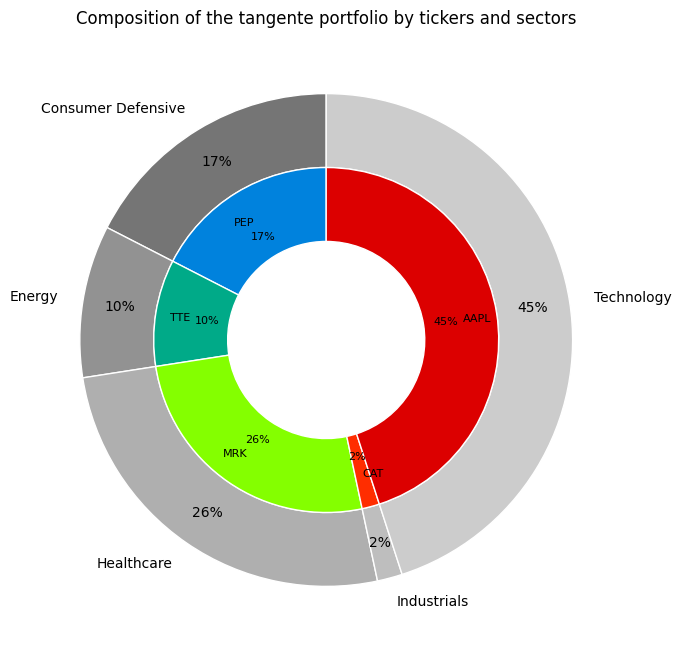

In [65]:
# tangente_portfolio_composition_60_esg_min_lower_bound_investment.png
PORTFOLIO.plot_tangente_portfolio_composition(GAMMA_VALUES, 
                                  risk_free_rate=RISK_FREE_RATE,
                                  max_esg_score=MAX_ESG_SCORE,
                                  fully_invested=True,
                                  long_only=True,
                                  sector_min_weight_x_dict=SECTOR_MIN_WEIGHT_X_DICT_SOME_MINS)

No solution found for esg score of 79.0
No solution found for esg score of 79.0


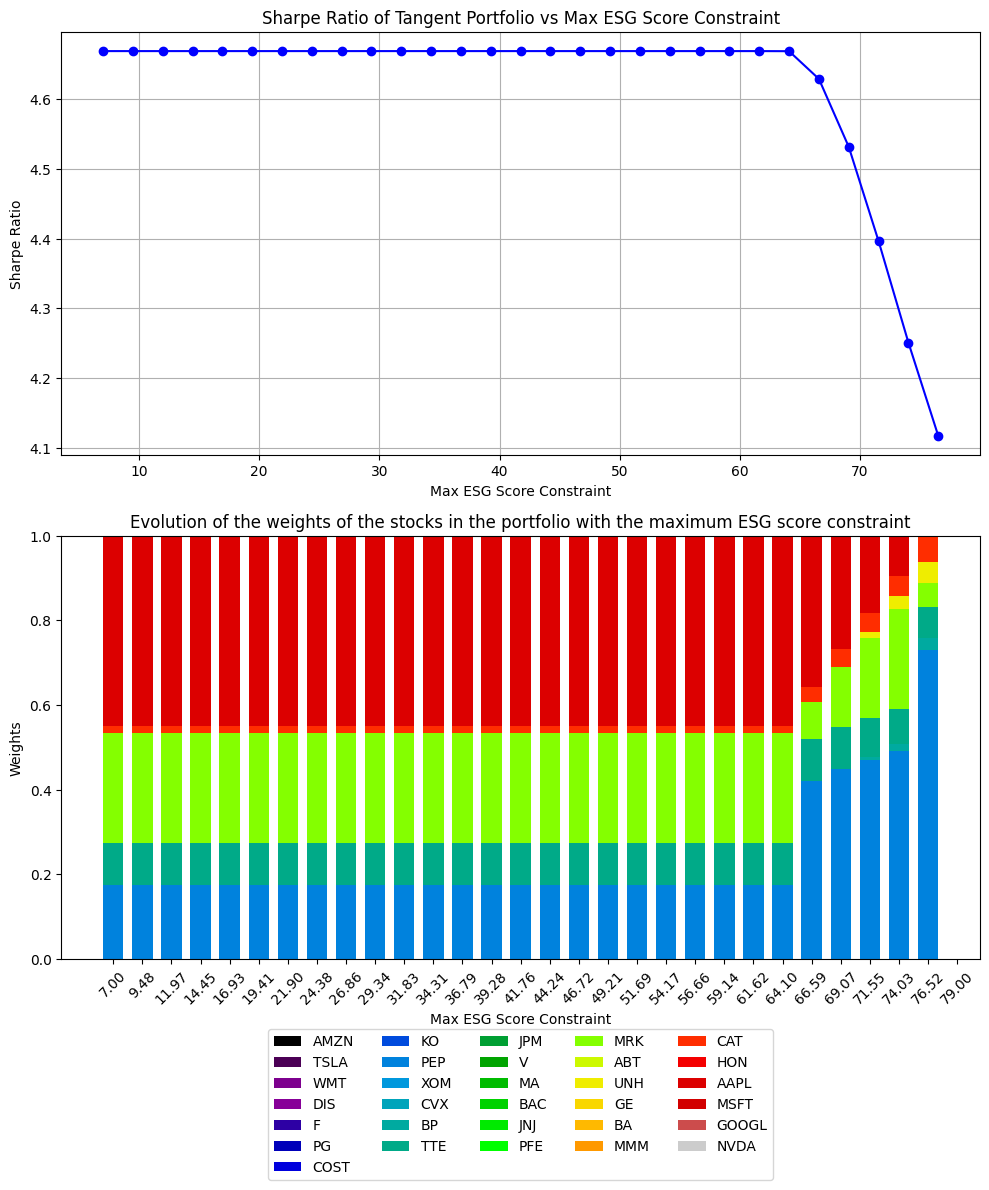

In [110]:
# sharpe_ratio_and_weights_varying_esg_limit_lower_bound_investment.png
PORTFOLIO.plot_sharpe_ratio_and_weights_varying_esg_limit(GAMMA_VALUES,
                                        risk_free_rate=RISK_FREE_RATE,
                                        max_esg_scores=MAX_ESG_SCORES,
                                        fully_invested=True,
                                        long_only=True,
                                        best_in_class_method=1,
                                        best_in_class_strategy='global',
                                        sector_min_weight_x_dict=SECTOR_MIN_WEIGHT_X_DICT_SOME_MINS)


No solution found for esg score of 79.0
No solution found for esg score of 79.0


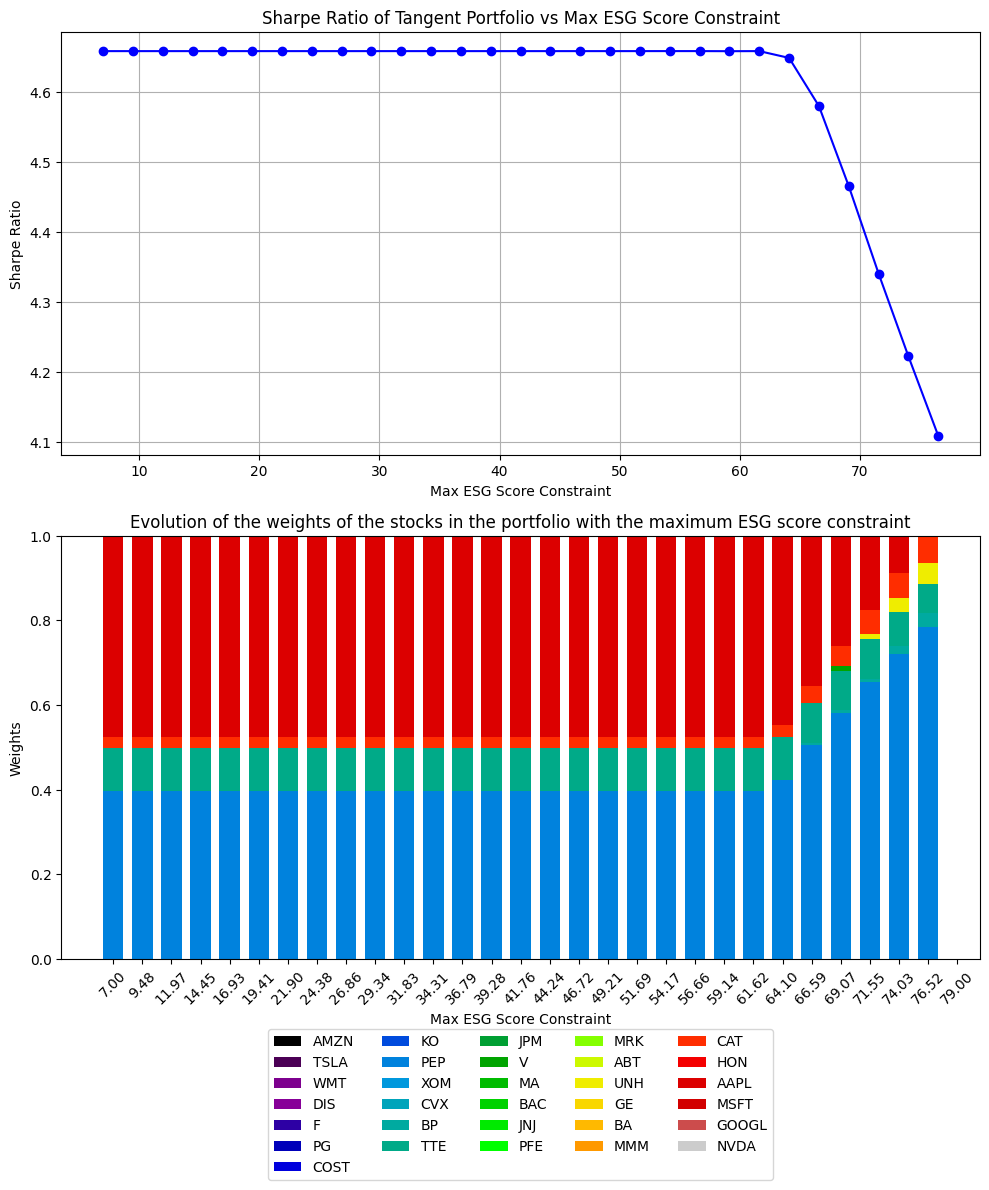

In [120]:
# sharpe_ratio_and_weights_varying_esg_limit_50_percent_global_lower_bound_investment.png
PORTFOLIO.plot_sharpe_ratio_and_weights_varying_esg_limit(GAMMA_VALUES,
                                        risk_free_rate=RISK_FREE_RATE,
                                        max_esg_scores=MAX_ESG_SCORES,
                                        fully_invested=True,
                                        long_only=True,
                                        best_in_class_method=0.5,
                                        best_in_class_strategy='global',
                                        sector_min_weight_x_dict=SECTOR_MIN_WEIGHT_X_DICT_SOME_MINS)


In [107]:
# # sharp_ratio_vs_max_score_60_esg_min_lower_bound_investment.png
# PORTFOLIO.plot_sharp_ratio_vs_max_score(GAMMA_VALUES,
#                                         risk_free_rate=RISK_FREE_RATE,
#                                         max_esg_scores=MAX_ESG_SCORES,
#                                         fully_invested=True,
#                                         long_only=True,
#                                         best_in_class_method=1,
#                                         best_in_class_strategy='global',
#                                         sector_min_weight_x_dict=SECTOR_MIN_WEIGHT_X_DICT_SOME_MINS)


In [108]:
# # weights_evolution_60_esg_min_all_lower_bound_investment.png
# PORTFOLIO.plot_weights_evolution(GAMMA_VALUES,
#                                  risk_free_rate=RISK_FREE_RATE,
#                                  max_esg_scores=MAX_ESG_SCORES,
#                                  fully_invested=True,
#                                  long_only=True, 
#                                  best_in_class_method=1,
#                                  best_in_class_strategy='global',
#                                  sector_min_weight_x_dict=SECTOR_MIN_WEIGHT_X_DICT_SOME_MINS)


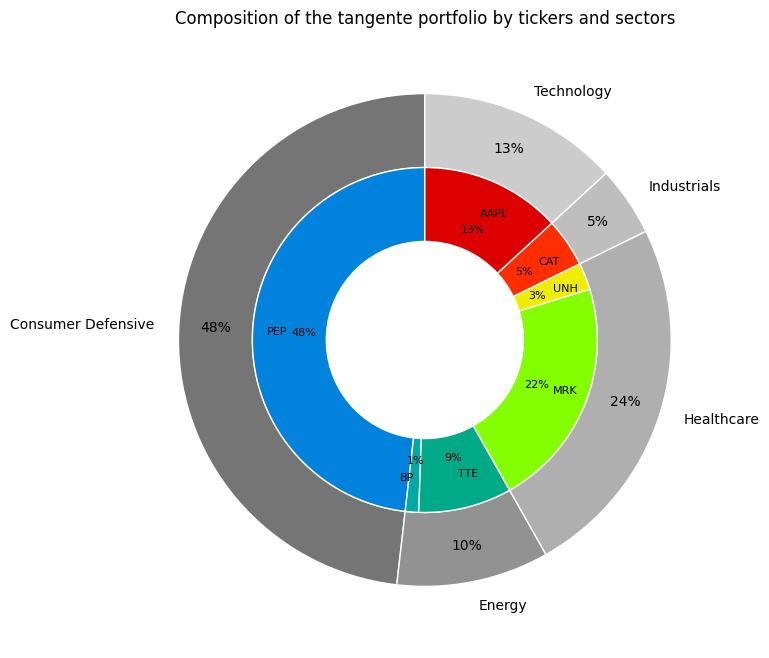

In [121]:
# tangente_portfolio_composition_73_esg_min_all_lower_bound_investment.png
PORTFOLIO.plot_tangente_portfolio_composition(gammas=GAMMA_VALUES, 
                                            risk_free_rate=RISK_FREE_RATE,
                                            max_esg_score=73,
                                            fully_invested=True,
                                            long_only=True,
                                            best_in_class_method=1,
                                            best_in_class_strategy='global',
                                            sector_min_weight_x_dict=SECTOR_MIN_WEIGHT_X_DICT_SOME_MINS)

### 1.4.2. Lower bound - 50% sector

No solution found for esg score of 79.0
No solution found for esg score of 79.0


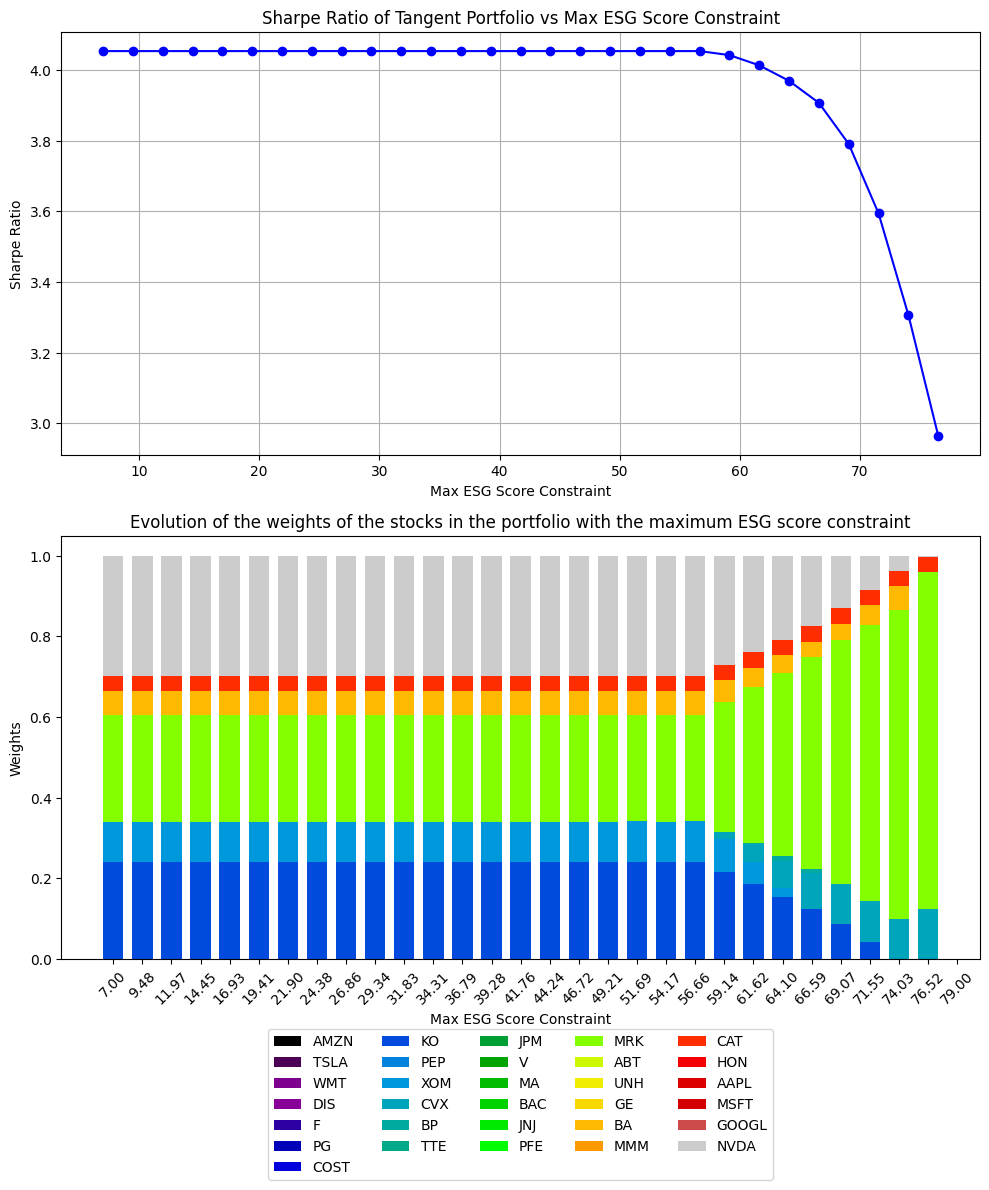

In [111]:
# sharpe_ratio_and_weights_varying_esg_limit_50_percent_sector_lower_bound_investment.png
PORTFOLIO.plot_sharpe_ratio_and_weights_varying_esg_limit(GAMMA_VALUES,
                                        risk_free_rate=RISK_FREE_RATE,
                                        max_esg_scores=MAX_ESG_SCORES,
                                        fully_invested=True,
                                        long_only=True,
                                        best_in_class_method=0.5,
                                        best_in_class_strategy='sector',
                                        sector_min_weight_x_dict=SECTOR_MIN_WEIGHT_X_DICT_SOME_MINS)


In [112]:
# # sharp_ratio_vs_max_score_60_esg_min_all_lower_bound_investment.png
# PORTFOLIO.plot_sharp_ratio_vs_max_score(GAMMA_VALUES,
#                                         risk_free_rate=RISK_FREE_RATE,
#                                         max_esg_scores=MAX_ESG_SCORES,
#                                         fully_invested=True,
#                                         long_only=True,
#                                         best_in_class_method=1,
#                                         best_in_class_strategy='sector',
#                                         sector_min_weight_x_dict=SECTOR_MIN_WEIGHT_X_DICT_SOME_MINS)



In [113]:
# # sharp_ratio_vs_max_score_60_esg_min_90_pourcent_sector_lower_bound_investment.png
# PORTFOLIO.plot_sharp_ratio_vs_max_score(GAMMA_VALUES,
#                                         risk_free_rate=RISK_FREE_RATE,
#                                         max_esg_scores=MAX_ESG_SCORES,
#                                         fully_invested=True,
#                                         long_only=True,
#                                         best_in_class_method=0.9,
#                                         best_in_class_strategy='sector',
#                                         sector_min_weight_x_dict=SECTOR_MIN_WEIGHT_X_DICT_SOME_MINS)



In [114]:
# # sharp_ratio_vs_max_score_60_esg_min_80_pourcent_sector_lower_bound_investment.png
# PORTFOLIO.plot_sharp_ratio_vs_max_score(GAMMA_VALUES,
#                                         risk_free_rate=RISK_FREE_RATE,
#                                         max_esg_scores=MAX_ESG_SCORES,
#                                         fully_invested=True,
#                                         long_only=True,
#                                         best_in_class_method=0.8,
#                                         best_in_class_strategy='sector',
#                                         sector_min_weight_x_dict=SECTOR_MIN_WEIGHT_X_DICT_SOME_MINS)



In [115]:
# # sharp_ratio_vs_max_score_60_esg_min_50_pourcent_sector_lower_bound_investment.png
# PORTFOLIO.plot_sharp_ratio_vs_max_score(GAMMA_VALUES,
#                                         risk_free_rate=RISK_FREE_RATE,
#                                         max_esg_scores=MAX_ESG_SCORES,
#                                         fully_invested=True,
#                                         long_only=True,
#                                         best_in_class_method=0.5,
#                                         best_in_class_strategy='sector',
#                                         sector_min_weight_x_dict=SECTOR_MIN_WEIGHT_X_DICT_SOME_MINS)



In [116]:
# # sharp_ratio_vs_max_score_60_esg_min_20_pourcent_sector_lower_bound_investment.png
# PORTFOLIO.plot_sharp_ratio_vs_max_score(GAMMA_VALUES,
#                                         risk_free_rate=RISK_FREE_RATE,
#                                         max_esg_scores=MAX_ESG_SCORES,
#                                         fully_invested=True,
#                                         long_only=True,
#                                         best_in_class_method=0.2,
#                                         best_in_class_strategy='sector',
#                                         sector_min_weight_x_dict=SECTOR_MIN_WEIGHT_X_DICT_SOME_MINS)



In [117]:
# # sharp_ratio_vs_max_score_60_esg_min_10_pourcent_sector_lower_bound_investment.png
# PORTFOLIO.plot_sharp_ratio_vs_max_score(GAMMA_VALUES,
#                                         risk_free_rate=RISK_FREE_RATE,
#                                         max_esg_scores=MAX_ESG_SCORES,
#                                         fully_invested=True,
#                                         long_only=True,
#                                         best_in_class_method=0.1,
#                                         best_in_class_strategy='sector',
#                                         sector_min_weight_x_dict=SECTOR_MIN_WEIGHT_X_DICT_SOME_MINS)



In [118]:
# # weights_evolution_60_esg_min_80_pourcent_sector_lower_bound_investment.png
# PORTFOLIO.plot_weights_evolution(GAMMA_VALUES,
#                                  risk_free_rate=RISK_FREE_RATE,
#                                  max_esg_scores=MAX_ESG_SCORES,
#                                  fully_invested=True,
#                                  long_only=True, 
#                                  best_in_class_method=0.8,
#                                  best_in_class_strategy='sector',
#                                  sector_min_weight_x_dict=SECTOR_MIN_WEIGHT_X_DICT_SOME_MINS)


In [119]:
# # weights_evolution_60_esg_min_50_pourcent_sector_lower_bound_investment.png
# PORTFOLIO.plot_weights_evolution(GAMMA_VALUES,
#                                  risk_free_rate=RISK_FREE_RATE,
#                                  max_esg_scores=MAX_ESG_SCORES,
#                                  fully_invested=True,
#                                  long_only=True, 
#                                  best_in_class_method=0.5,
#                                  best_in_class_strategy='sector',
#                                  sector_min_weight_x_dict=SECTOR_MIN_WEIGHT_X_DICT_SOME_MINS)


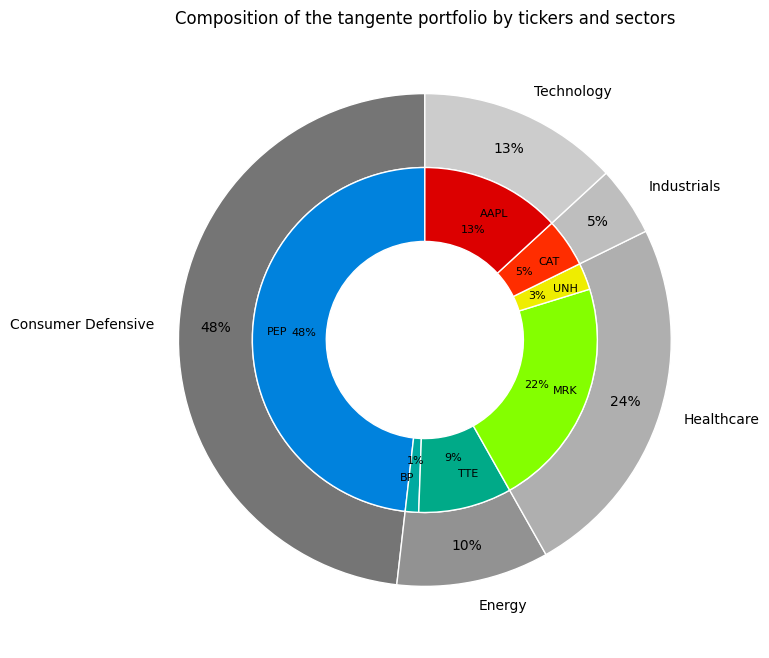

In [80]:
# weights_evolution_73_esg_min_80_pourcent_sector_lower_bound_investment.png
PORTFOLIO.plot_tangente_portfolio_composition(gammas=GAMMA_VALUES, 
                                            risk_free_rate=RISK_FREE_RATE,
                                            max_esg_score=73,
                                            fully_invested=True,
                                            long_only=True,
                                            best_in_class_method=0.8,
                                            best_in_class_strategy='sector',
                                            sector_min_weight_x_dict=SECTOR_MIN_WEIGHT_X_DICT_SOME_MINS)

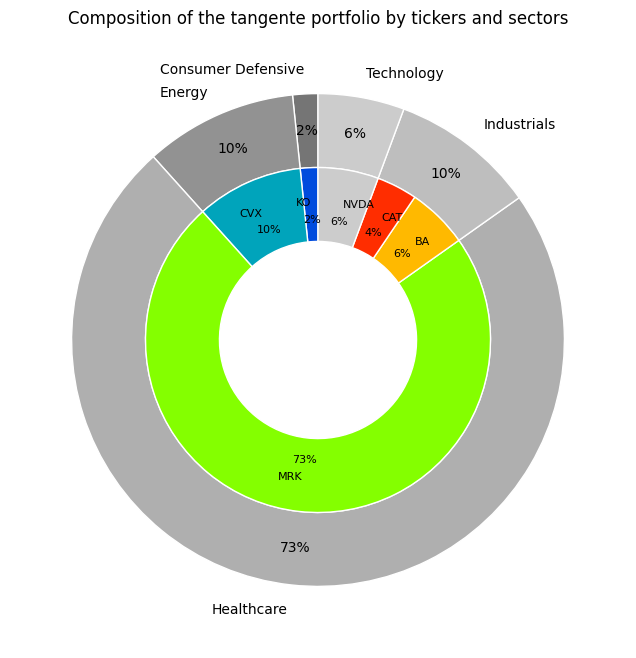

In [81]:
# weights_evolution_73_esg_min_50_pourcent_sector_lower_bound_investment.png
PORTFOLIO.plot_tangente_portfolio_composition(gammas=GAMMA_VALUES, 
                                            risk_free_rate=RISK_FREE_RATE,
                                            max_esg_score=73,
                                            fully_invested=True,
                                            long_only=True,
                                            best_in_class_method=0.5,
                                            best_in_class_strategy='sector',
                                            sector_min_weight_x_dict=SECTOR_MIN_WEIGHT_X_DICT_SOME_MINS)

# 2. Test portfolio performance on unseen data

In [268]:
def check_if_dates_are_correct(T0, T1, T2):
    if datetime.strptime(T1, '%Y-%m-%d') < get_first_date_with_all_msci_score_available(msci_score):
        print("ERROR: END_DATE is before the first date with all msci score available.")
        T1 = get_first_date_with_all_msci_score_available(msci_score)
        print(f"T1 is now {T1}, but you can change it.")
    else:
        print("Thanks for having entered a valid end date !")


def get_tangente_ptf_weights(T0, 
                             T1,
                             msci_score, 
                             TICKERS, 
                             INTERVAL, 
                             RISK_FREE_RATE, 
                             FREQUENCY_RETURNS, 
                             GAMMA_VALUES, 
                             min_esg_score,
                             fully_invested=True,
                             long_only=True,
                             best_in_class_method=1,
                             best_in_class_strategy='global',
                             sector_min_weight_x_dict=None):

    msci_last_esg_score = get_last_esg_scores(msci_score, T1)

    PTF = Portfolio(tickers=TICKERS,
                    start_date=T0,
                    end_date=T1,
                    interval=INTERVAL,
                    msci_data=msci_last_esg_score,
                    frequency_returns=FREQUENCY_RETURNS)
    
    PTF.download_data()

    PTF.get_optimal_portfolio_markowitz(gammas=GAMMA_VALUES, 
                                                  risk_free_rate=RISK_FREE_RATE,
                                                  max_esg_score=min_esg_score,
                                                  fully_invested=fully_invested,
                                                  long_only=long_only,
                                                  best_in_class_method=best_in_class_method,
                                                  best_in_class_strategy=best_in_class_strategy,
                                                  sector_min_weight_x_dict=sector_min_weight_x_dict)
    
    weights = PTF.weights_tangente_portfolio
    esg_score_tangent = PTF.score_esg_tangent
    

    return weights, esg_score_tangent

def test_tangente_ptf_weights(weights,
                              T1_bis,
                              T2,
                              msci_score,
                              TICKERS,
                              INTERVAL,
                              FREQUENCY_RETURNS):
    
    msci_last_esg_score = get_last_esg_scores(msci_score, T2)

    PTF = Portfolio(tickers=TICKERS,
                    start_date=T1_bis,
                    end_date=T2,
                    interval=INTERVAL,
                    msci_data=msci_last_esg_score,
                    frequency_returns=FREQUENCY_RETURNS)
    
    PTF.get_net_returns()

    return weights, PTF.net_returns, msci_last_esg_score


def get_tangent_ptf_evolution(T0, 
                              T1, 
                              T1_bis,
                              T2, 
                              msci_score, 
                              TICKERS, 
                              INTERVAL, 
                              RISK_FREE_RATE, 
                              FREQUENCY_RETURNS, 
                              GAMMA_VALUES, 
                              min_esg_score,
                              fully_invested=True,
                              long_only=True,
                              best_in_class_method=1,
                              best_in_class_strategy='global',
                              sector_min_weight_x_dict=None,
                              initial_value=None):
    
    weights, esg_score_tangent = get_tangente_ptf_weights(T0, 
                             T1,
                             msci_score, 
                             TICKERS, 
                             INTERVAL, 
                             RISK_FREE_RATE, 
                             FREQUENCY_RETURNS, 
                             GAMMA_VALUES, 
                             min_esg_score,
                             fully_invested,
                             long_only,
                             best_in_class_method,
                             best_in_class_strategy,
                             sector_min_weight_x_dict)
    
    weights, net_returns, msci_last_esg_score = test_tangente_ptf_weights(weights,
                                                                      T1_bis,
                                                                      T2,
                                                                      msci_score,
                                                                      TICKERS,
                                                                      INTERVAL,
                                                                      FREQUENCY_RETURNS)
                              


    # Calculate weighted returns
    weighted_returns = net_returns.dot(weights)

    # Calculate portfolio value
    portfolio_return = (1 + weighted_returns).prod()

    if initial_value is not None:
        portfolio_value = initial_value * portfolio_return
        print("Portfolio value:", portfolio_value)

    print("Portfolio return:", round(portfolio_return, 2))
    print("Portfolio esg score at T1:", esg_score_tangent)
    print("Portfolio esg score at T2:", np.array(msci_last_esg_score) @ weights)


In [269]:
T0='2020-01-01'
T1='2022-12-01'
T1_bis='2022-01-01'
T2='2023-12-01'

check_if_dates_are_correct(T0, T1, T2)

Thanks for having entered a valid end date !


In [270]:
get_tangent_ptf_evolution(T0, 
                              T1, 
                              T1_bis,
                              T2, 
                              msci_score, 
                              TICKERS, 
                              INTERVAL, 
                              RISK_FREE_RATE, 
                              FREQUENCY_RETURNS, 
                              GAMMA_VALUES, 
                              min_esg_score=70,
                              fully_invested=True,
                              long_only=True,
                              best_in_class_method=1,
                              best_in_class_strategy='global',
                              sector_min_weight_x_dict=SECTOR_MIN_WEIGHT_X_DICT_SOME_MINS,
                              initial_value=100)

[                       0%%                      ]

[*********************100%%**********************]  31 of 31 completed
[*********************100%%**********************]  31 of 31 completed
Portfolio value: 12253.236795510133
Portfolio return: 122.53
Portfolio esg score at T1: 70.00000000000105
Portfolio esg score at T2: 69.06617578911543


In [271]:
for max_score in list(np.linspace(65, np.max(msci_last_esg_score), 15)):
    print(f"Max score: {max_score}")
    get_tangent_ptf_evolution(T0, 
                            T1, 
                            T1_bis,
                            T2, 
                            msci_score, 
                            TICKERS, 
                            INTERVAL, 
                            RISK_FREE_RATE, 
                            FREQUENCY_RETURNS, 
                            GAMMA_VALUES, 
                            min_esg_score=max_score,
                            fully_invested=True,
                            long_only=True,
                            best_in_class_method=1,
                            best_in_class_strategy='global',
                            sector_min_weight_x_dict=None)

Max score: 65.0


[*********************100%%**********************]  31 of 31 completed
[*********************100%%**********************]  31 of 31 completed
Portfolio return: 1887.04
Portfolio esg score at T1: 65.00000000000018
Portfolio esg score at T2: 61.65000636123805
Max score: 66.0
[*********************100%%**********************]  31 of 31 completed
[*********************100%%**********************]  31 of 31 completed
Portfolio return: 4846.39
Portfolio esg score at T1: 66.00000000000021
Portfolio esg score at T2: 62.367966595647424
Max score: 67.0
[*********************100%%**********************]  31 of 31 completed
[*********************100%%**********************]  31 of 31 completed
Portfolio return: 11028.13
Portfolio esg score at T1: 67.00000000000021
Portfolio esg score at T2: 63.112651058049806
Max score: 68.0
[*********************100%%**********************]  31 of 31 completed
[*********************100%%**********************]  31 of 31 completed
Portfolio return: 23657.36
Portfo

In [ ]:
# get weights of tangent portfolio under desired constraints
# test allocation return, vol, (sharp ratio) and esg score Y months later

In [ ]:
#TODO

#2. Backtest analyses
# train l'optimisation entre T0 et T1 -> renvoie des weights
# test les weights sur la période T1 et T2 -> renvoie un score de performance + analyse de si on respecte encore les contraintes esg en T2 (moyenne, variance etc.)
# faire cela pour les différents cas précédement identifiés (1 global, 0.5 global, 0.5 local ET ajout ou non de contraintes sectorielles)

#3. comparer à Sustainalytics ajrd (interval de confiance sur le score ESG?)

# Récap: vérifier les contraintes au cours du temps (les plots) et comparer à des indices ou des ptf equal weights.
# Répéter l'allocation chaque année et comparer comment la frontière efficiente évolue au cours du temps